# PCA Analysis with clustering


In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from kneed import KneeLocator
from functions.data_functions import load_data, connect_to_database
import warnings
warnings.filterwarnings(action='ignore')
from scipy import stats

Load the data

In [6]:
t1_df = load_data('BEACON', 't1_measures')
t2_df = load_data('BEACON', 't2_measures')
participant_index = load_data('BEACON', 'participant_index')

reorder t1 database based on order of time point 2. Then merge dataframes and drop null values to do PCA.

In [7]:
t1_df = pd.merge(participant_index['t1'], t1_df, left_on='t1', right_on='G_Number', how='left').drop(['t1', 'index'], axis=1)
t1_df

,G_Number,aq_score_t1,anxiety_t1,depression_t1,bmi_t1,oci_score_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1,global_score_t1,group
0,G1038,2.0,4.0,2.0,22.038567,1.0,0.0,0.0,0.0,0.375,0.2,0.14000,HC_t1
1,G1010,2.0,1.0,0.0,22.718974,3.0,1.0,0.0,0.0,0.375,0.2,0.14000,HC_t1
2,G1014,2.0,3.0,2.0,23.722811,0.0,0.0,0.0,0.0,0.875,0.0,0.22000,HC_t1
3,G1056,NaN,NaN,NaN,20.614236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HC_t1
4,G1023,2.0,8.0,4.0,23.612751,19.0,0.0,0.2,0.2,3.125,3.4,1.73000,HC_t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,G2141,4.0,12.0,7.0,16.757637,16.0,27.0,4.6,3.2,5.625,4.2,4.40625,AN_t1
130,G2138,0.0,8.0,3.0,16.602388,4.0,16.0,0.0,0.2,3.250,1.2,1.16250,AN_t1
131,G2140,2.0,8.0,7.0,14.933853,9.0,32.0,5.0,4.6,6.000,4.8,5.10000,AN_t1
132,G2105,2.0,10.0,8.0,18.630735,43.0,27.0,4.6,3.2,4.875,3.2,3.97000,AN_t1


In [4]:
t2_df

,index,B_Number,aq_score_t2,anxiety_t2,depression_t2,bmi_t2,oci_score_t2,wsas_score_t2,restraint,eating_concern,shape_concern,weight_concern,global_score_t2,group
0,0,B1002,0.0,6.0,1.0,33.017818,4.0,0.0,1.8,0.2,1.625,1.6,1.30625,HC
1,1,B1003,1.0,4.0,2.0,22.832879,1.0,0.0,0.0,0.0,0.000,0.0,0.00000,HC
2,2,B1004,3.0,9.0,3.0,24.683905,27.0,2.0,1.2,0.8,2.250,0.4,1.16250,HC
3,3,B1006,6.0,11.0,3.0,21.218317,10.0,7.0,1.2,0.8,1.500,1.0,1.12500,HC
4,4,B1007,2.0,6.0,7.0,24.034407,11.0,0.0,2.2,0.4,2.750,2.0,1.83750,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,129,B2091,5.0,14.0,11.0,15.084373,24.0,24.0,2.4,1.6,4.750,2.0,2.68750,AN
130,130,B2092,2.0,13.0,5.0,19.467401,15.0,16.0,1.4,2.0,3.250,1.6,2.06250,AN
131,131,B2093,1.0,11.0,16.0,14.733633,9.0,29.0,6.0,4.6,5.750,4.8,5.28750,AN
132,132,B2094,1.0,15.0,7.0,18.365473,53.0,34.0,5.0,5.6,5.875,4.4,5.21875,AN


In [139]:
pca_df = pd.concat([t1_df.drop('group', axis=1), t2_df], axis=1).rename(columns={'restraint':'restraint_score_t2', 'eating_concern':'eating_concern_score_t2', 
                                                           'shape_concern': 'shape_concern_score_t2', 'weight_concern': 'weight_concern_score_t2' })
pca_df

,G_Number,aq_score_t1,anxiety_t1,depression_t1,bmi_t1,oci_score_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,...,depression_t2,bmi_t2,oci_score_t2,wsas_score_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,global_score_t2,group
0,G1038,2.0,4.0,2.0,22.038567,1.0,0.0,0.0,0.0,0.375,...,1.0,33.017818,4.0,0.0,1.8,0.2,1.625,1.6,1.30625,HC
1,G1010,2.0,1.0,0.0,22.718974,3.0,1.0,0.0,0.0,0.375,...,2.0,22.832879,1.0,0.0,0.0,0.0,0.000,0.0,0.00000,HC
2,G1014,2.0,3.0,2.0,23.722811,0.0,0.0,0.0,0.0,0.875,...,3.0,24.683905,27.0,2.0,1.2,0.8,2.250,0.4,1.16250,HC
3,G1056,NaN,NaN,NaN,20.614236,NaN,NaN,NaN,NaN,NaN,...,3.0,21.218317,10.0,7.0,1.2,0.8,1.500,1.0,1.12500,HC
4,G1023,2.0,8.0,4.0,23.612751,19.0,0.0,0.2,0.2,3.125,...,7.0,24.034407,11.0,0.0,2.2,0.4,2.750,2.0,1.83750,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,G2141,4.0,12.0,7.0,16.757637,16.0,27.0,4.6,3.2,5.625,...,11.0,15.084373,24.0,24.0,2.4,1.6,4.750,2.0,2.68750,AN
130,G2138,0.0,8.0,3.0,16.602388,4.0,16.0,0.0,0.2,3.250,...,5.0,19.467401,15.0,16.0,1.4,2.0,3.250,1.6,2.06250,AN
131,G2140,2.0,8.0,7.0,14.933853,9.0,32.0,5.0,4.6,6.000,...,16.0,14.733633,9.0,29.0,6.0,4.6,5.750,4.8,5.28750,AN
132,G2105,2.0,10.0,8.0,18.630735,43.0,27.0,4.6,3.2,4.875,...,7.0,18.365473,53.0,34.0,5.0,5.6,5.875,4.4,5.21875,AN


In [140]:
print(pca_df.isnull().sum())
#print(f'-'*100,)
#print(t2_df.isnull().sum())

G_Number                    0
aq_score_t1                 8
anxiety_t1                 11
depression_t1              11
bmi_t1                      2
oci_score_t1                8
wsas_score_t1               8
restraint_score_t1          8
eating_concern_score_t1     8
shape_concern_score_t1      8
weight_concern_score_t1     8
global_score_t1             8
index                       0
B_Number                    0
aq_score_t2                 1
anxiety_t2                  1
depression_t2               1
bmi_t2                      7
oci_score_t2                1
wsas_score_t2               1
restraint_score_t2          1
eating_concern_score_t2     1
shape_concern_score_t2      1
weight_concern_score_t2     1
global_score_t2             1
group                       1
dtype: int64


In [141]:
pca_df = pca_df.dropna().reset_index(drop=True)
pca_df.describe()

,aq_score_t1,anxiety_t1,depression_t1,bmi_t1,oci_score_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1,...,anxiety_t2,depression_t2,bmi_t2,oci_score_t2,wsas_score_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,global_score_t2
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,3.336207,8.448276,6.129310,19.518736,16.258621,13.956897,2.210345,1.882759,2.993534,2.450000,...,9.775862,6.112069,20.405422,18.767241,11.189655,1.996552,1.579310,2.797414,2.267241,2.160129
std,2.310445,4.259710,4.102025,3.541317,13.644633,11.850806,1.884277,1.729553,2.069699,1.925549,...,4.916850,4.285002,4.456076,14.698925,11.467848,1.776167,1.556223,1.833687,1.673101,1.582331
min,0.000000,0.000000,0.000000,13.109410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,14.239943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,3.000000,17.124883,4.000000,1.000000,0.400000,0.200000,0.875000,0.600000,...,6.000000,3.000000,17.579813,6.000000,0.750000,0.550000,0.200000,1.343750,1.000000,0.900000
50%,3.000000,8.000000,5.500000,18.908028,13.000000,14.500000,2.200000,1.600000,3.375000,2.400000,...,10.000000,6.000000,19.237998,15.000000,7.000000,1.400000,1.200000,2.500000,1.800000,1.806250
75%,5.000000,12.000000,9.000000,21.145967,26.000000,24.000000,3.800000,3.400000,4.875000,3.800000,...,14.000000,9.000000,22.584420,27.250000,20.250000,3.450000,2.450000,4.500000,3.300000,3.259375
max,10.000000,19.000000,17.000000,30.777449,49.000000,37.000000,5.800000,5.800000,6.000000,6.000000,...,20.000000,16.000000,36.004568,56.000000,38.000000,6.000000,5.800000,6.000000,6.000000,5.550000


In [44]:
pca_df.columns

Index(['G_Number', 'aq_score_t1', 'anxiety_t1', 'depression_t1', 'bmi_t1',
       'oci_score_t1', 'wsas_score_t1', 'restraint_score_t1',
       'eating_concern_score_t1', 'shape_concern_score_t1',
       'weight_concern_score_t1', 'global_score_t1', 'group', 'index',
       'B_Number', 'aq_score_t2', 'anxiety_t2', 'depression_t2', 'bmi_t2',
       'oci_score_t2', 'wsas_score_t2', 'restraint_score_t2',
       'eating_concern_score_t2', 'shape_concern_score_t2',
       'weight_concern_score_t2', 'global_score_t2', 'group'],
      dtype='object')

## Preprocessing

Due to the data being in different units this can cause some measures to be weighted more in the segmentation model compared with others. For example a difference in the ede-q between HC participants could be 0.5 however there could be a difference of 10 between the lowest and highest BMI.

To prevent this all the data is standardized by removing the mean and scaling to unit variance.

```z = (x - u) / s```

Where u is the mean and s is the standard variaces. 

In [87]:
t1_pca = pca_df[['aq_score_t1','anxiety_t1', 'depression_t1', 'oci_score_t1', 'bmi_t1', 'wsas_score_t1', 'restraint_score_t1', 'eating_concern_score_t1', 'shape_concern_score_t1', 'weight_concern_score_t1']]
t2_pca = pca_df[['aq_score_t2','anxiety_t2', 'depression_t2', 'oci_score_t2' ,'bmi_t2', 'wsas_score_t2', 'restraint_score_t2', 'eating_concern_score_t2', 'shape_concern_score_t2', 'weight_concern_score_t2']]

In [88]:
t1_pca

,aq_score_t1,anxiety_t1,depression_t1,oci_score_t1,bmi_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1
0,2.0,4.0,2.0,1.0,22.038567,0.0,0.0,0.0,0.375,0.2
1,2.0,1.0,0.0,3.0,22.718974,1.0,0.0,0.0,0.375,0.2
2,2.0,3.0,2.0,0.0,23.722811,0.0,0.0,0.0,0.875,0.0
3,2.0,8.0,4.0,19.0,23.612751,0.0,0.2,0.2,3.125,3.4
4,7.0,6.0,6.0,22.0,20.559211,6.0,1.8,1.0,3.375,1.8
...,...,...,...,...,...,...,...,...,...,...
111,4.0,12.0,7.0,16.0,16.757637,27.0,4.6,3.2,5.625,4.2
112,0.0,8.0,3.0,4.0,16.602388,16.0,0.0,0.2,3.250,1.2
113,2.0,8.0,7.0,9.0,14.933853,32.0,5.0,4.6,6.000,4.8
114,2.0,10.0,8.0,43.0,18.630735,27.0,4.6,3.2,4.875,3.2


In [89]:
scaler = StandardScaler()
t1_scaler = scaler.fit_transform(t1_pca)
t2_scaler = scaler.fit_transform(t2_pca)

## Dimensionality Reduction

In [90]:
t1_pca_model = PCA()
t1_pca_model.fit(t1_scaler)
t1_pca_scores = t1_pca_model.transform(t1_scaler)

t1_wcss = []

for cluster_number in range(1,21):
    kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    kmeans_pca.fit(t1_pca_scores)
    t1_wcss.append(kmeans_pca.inertia_)

t1_kl = KneeLocator(range(1, 21), t1_wcss, curve="convex", direction="decreasing")
print(t1_kl.elbow)

4


Text(0, 0.5, 'Cumulative Explained variance')

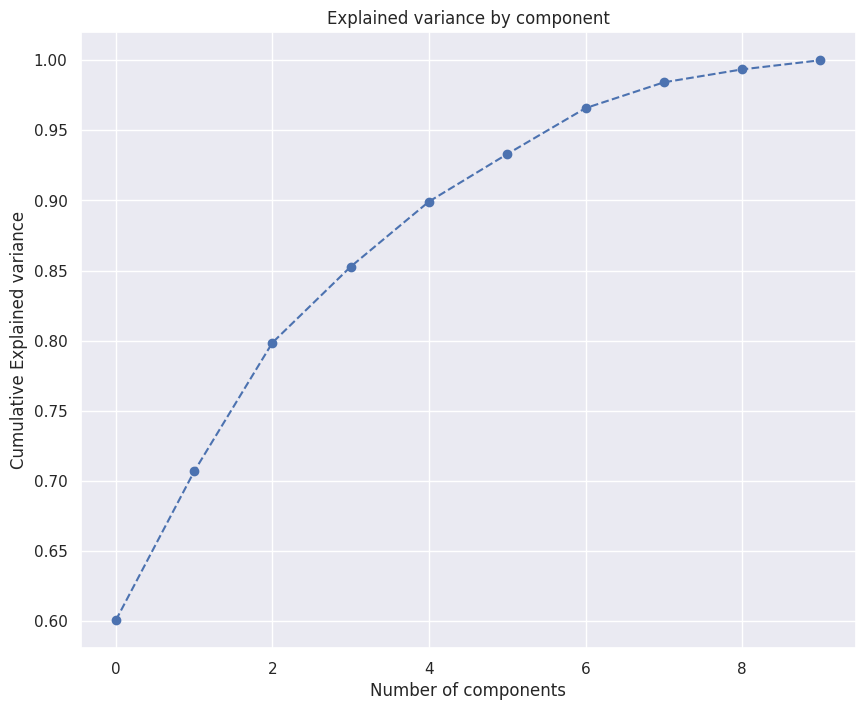

In [91]:
plt.figure(figsize=(10,8))
plt.plot(t1_pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

Text(0, 0.5, 'WCSS')

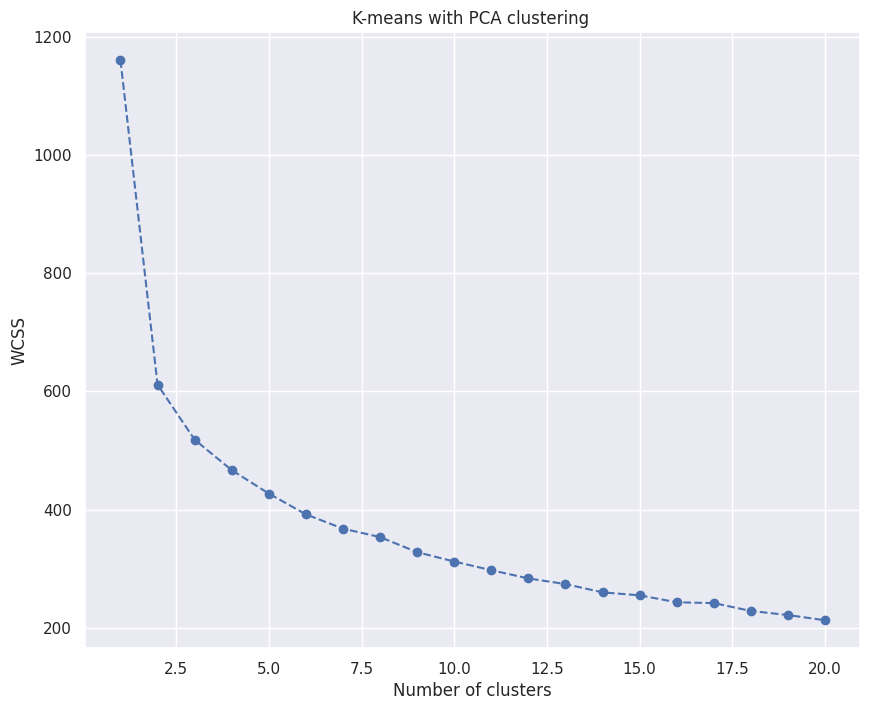

In [92]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), t1_wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [93]:
t2_pca_model = PCA()
t2_pca_model.fit(t2_scaler)
t2_pca_scores = t2_pca_model.transform(t2_scaler)

t2_wcss = []

for cluster_number in range(1,21):
    t2_kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    t2_kmeans_pca.fit(t1_pca_scores)
    t2_wcss.append(t2_kmeans_pca.inertia_)

t2_kl = KneeLocator(range(1, 21), t2_wcss, curve="convex", direction="decreasing")
print(t2_kl.elbow)

4


Text(0, 0.5, 'Cumulative Explained variance')

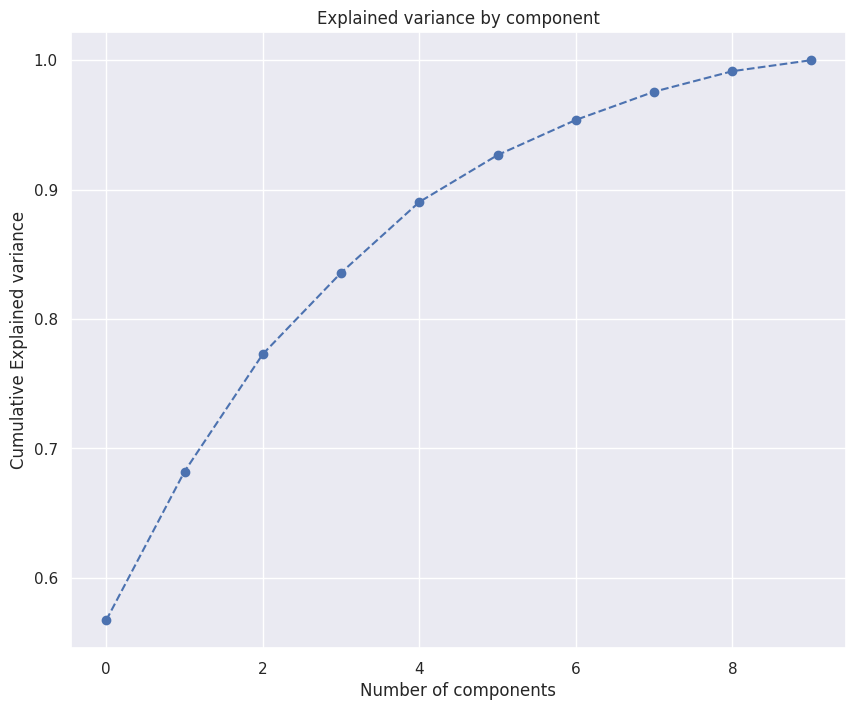

In [94]:
plt.figure(figsize=(10,8))
plt.plot(t2_pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

Text(0, 0.5, 'WCSS')

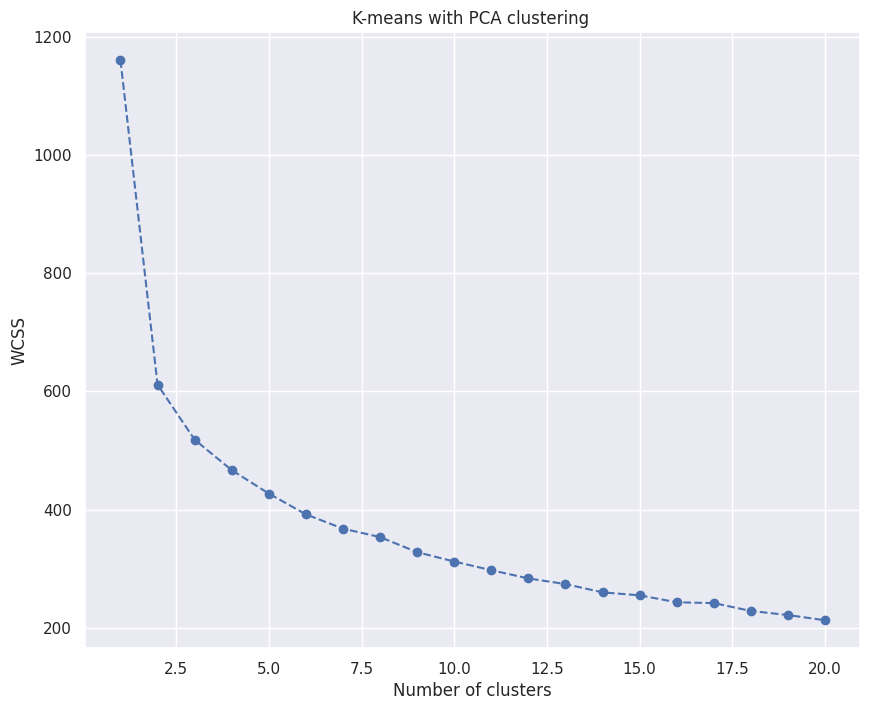

In [95]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), t2_wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [96]:
print('t1 explained variance ratio:\n', t1_pca_model.explained_variance_ratio_)
print('\nt2 explained variance ratio:\n', t2_pca_model.explained_variance_ratio_)

t1 explained variance ratio:
 [0.60056401 0.10611978 0.09187182 0.0541966  0.0464628  0.03388395
 0.03275203 0.01840937 0.00922211 0.00651754]

t2 explained variance ratio:
 [0.56719833 0.11492695 0.09076338 0.06287469 0.05470458 0.03627441
 0.02716013 0.02182109 0.01583087 0.00844557]


## Dataframes

In [97]:
t1_pca_group = pd.concat([pca_df['G_Number'], t1_pca], axis=1)
t1_df_seg = pd.concat([t1_pca_group, pd.DataFrame(t1_pca_scores)], axis=1)
t1_df_seg.columns.values[11:14] = ['comp_1', 'comp_2', 'comp_3']
t1_df_seg = t1_df_seg.drop([3 , 4, 5, 6, 7, 8,9,], axis=1)
t1_df_seg

,G_Number,aq_score_t1,anxiety_t1,depression_t1,oci_score_t1,bmi_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1,comp_1,comp_2,comp_3
0,G1038,2.0,4.0,2.0,1.0,22.038567,0.0,0.0,0.0,0.375,0.2,-3.330858,-0.038814,0.053992
1,G1010,2.0,1.0,0.0,3.0,22.718974,1.0,0.0,0.0,0.375,0.2,-3.675288,-0.306146,0.425690
2,G1014,2.0,3.0,2.0,0.0,23.722811,0.0,0.0,0.0,0.875,0.0,-3.462899,-0.216312,0.492204
3,G1023,2.0,8.0,4.0,19.0,23.612751,0.0,0.2,0.2,3.125,3.4,-1.433229,-0.125526,1.165611
4,G1022,7.0,6.0,6.0,22.0,20.559211,6.0,1.8,1.0,3.375,1.8,-0.338717,1.220852,0.823205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,G2141,4.0,12.0,7.0,16.0,16.757637,27.0,4.6,3.2,5.625,4.2,2.448469,-0.701650,-0.410376
112,G2138,0.0,8.0,3.0,4.0,16.602388,16.0,0.0,0.2,3.250,1.2,-1.598782,-0.656621,-1.344820
113,G2140,2.0,8.0,7.0,9.0,14.933853,32.0,5.0,4.6,6.000,4.8,2.620445,-2.088359,-0.999341
114,G2105,2.0,10.0,8.0,43.0,18.630735,27.0,4.6,3.2,4.875,3.2,2.303525,-0.276979,0.238688


<AxesSubplot: xlabel='comp_1', ylabel='comp_2'>

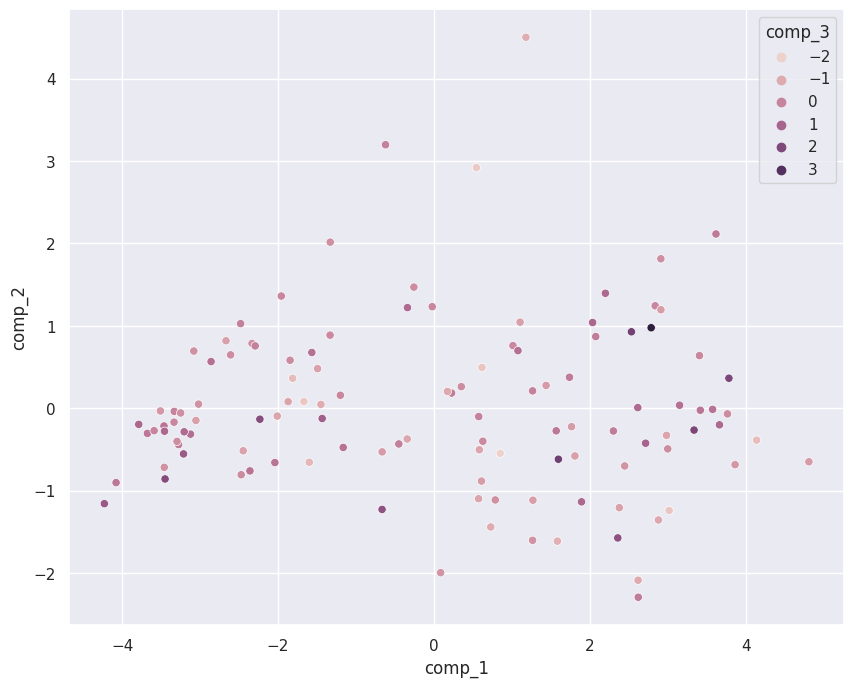

In [98]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', 'comp_3', data=t1_df_seg, hue='segment')

In [128]:
t2_pca_group = pd.concat([pca_df['B_Number'], t2_pca], axis=1)
t2_df_seg = pd.concat([t2_pca_group, pd.DataFrame(t2_pca_scores)], axis=1)
t2_df_seg.columns.values[11:14] = ['comp_1', 'comp_2', 'comp_3']
t2_df_seg = t2_df_seg.drop([3, 4, 5, 6, 7, 8, 9], axis=1)
t2_df_seg

,B_Number,aq_score_t2,anxiety_t2,depression_t2,oci_score_t2,bmi_t2,wsas_score_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,comp_1,comp_2,comp_3
0,B1002,0.0,6.0,1.0,4.0,33.017818,0.0,1.8,0.2,1.625,1.6,-2.809328,-1.496931,2.171887
1,B1003,1.0,4.0,2.0,1.0,22.832879,0.0,0.0,0.0,0.000,0.0,-3.492470,-0.294061,-0.220119
2,B1004,3.0,9.0,3.0,27.0,24.683905,2.0,1.2,0.8,2.250,0.4,-1.462532,0.474414,0.787114
3,B1007,2.0,6.0,7.0,11.0,24.034407,0.0,2.2,0.4,2.750,2.0,-1.242177,-0.632335,0.733666
4,B1009,7.0,10.0,6.0,18.0,31.503997,4.0,1.2,1.8,2.625,1.4,-0.717742,1.259611,2.164392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,B2091,5.0,14.0,11.0,24.0,15.084373,24.0,2.4,1.6,4.750,2.0,1.922807,0.933933,-0.793016
112,B2092,2.0,13.0,5.0,15.0,19.467401,16.0,1.4,2.0,3.250,1.6,0.064752,-0.222998,-0.289193
113,B2093,1.0,11.0,16.0,9.0,14.733633,29.0,6.0,4.6,5.750,4.8,3.866470,-2.232530,-0.834078
114,B2094,1.0,15.0,7.0,53.0,18.365473,34.0,5.0,5.6,5.875,4.4,4.305718,-1.430161,0.215596


<AxesSubplot: xlabel='comp_1', ylabel='comp_2'>

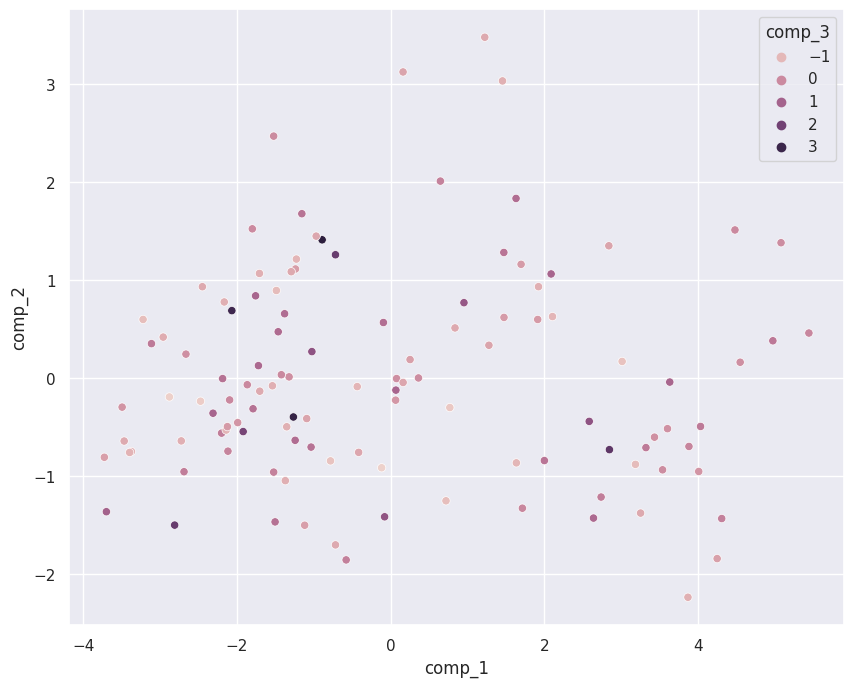

In [100]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', 'comp_3', data=t2_df_seg, hue='segment')

## Examine the relationship between components and measures

In [101]:
measures_t1 = ['oci_score_t1', 'bmi_t1', 'anxiety_t1', 'depression_t1', 'restraint_score_t1', 'eating_concern_score_t1', 'shape_concern_score_t1', 'weight_concern_score_t1', 'aq_score_t1', 'wsas_score_t1']

correlations_t1 = {
    'comp_1': {},
    'comp_2': {},
    'comp_3': {},
}

for component in correlations_t1.keys():
    for measure in measures_t1:
        correlations_t1[component][measure] =  stats.pearsonr(t1_df_seg[component], t1_df_seg[measure])[0]

measures_t2 = ['oci_score_t2', 'bmi_t2', 'anxiety_t2', 'depression_t2', 'restraint_score_t2', 'eating_concern_score_t2', 'shape_concern_score_t2', 'weight_concern_score_t2', 'aq_score_t2', 'wsas_score_t2']

correlations_t2 = {
    'comp_1': {},
    'comp_2': {},
    'comp_3': {},
}

for component in correlations_t2.keys():
    for measure in measures_t2:
        correlations_t2[component][measure] =  stats.pearsonr(t2_df_seg[component], t2_df_seg[measure])[0]


{'oci_score_t1': 0.6622189896969178, 'bmi_t1': -0.4552144835358721, 'anxiety_t1': 0.7758885570875577, 'depression_t1': 0.7661931904581183, 'restraint_score_t1': 0.8800623220287165, 'eating_concern_score_t1': 0.9168811086874447, 'shape_concern_score_t1': 0.8966760076481295, 'weight_concern_score_t1': 0.8821863772060806, 'aq_score_t1': 0.5345325541516858, 'wsas_score_t1': 0.8292432972812651}


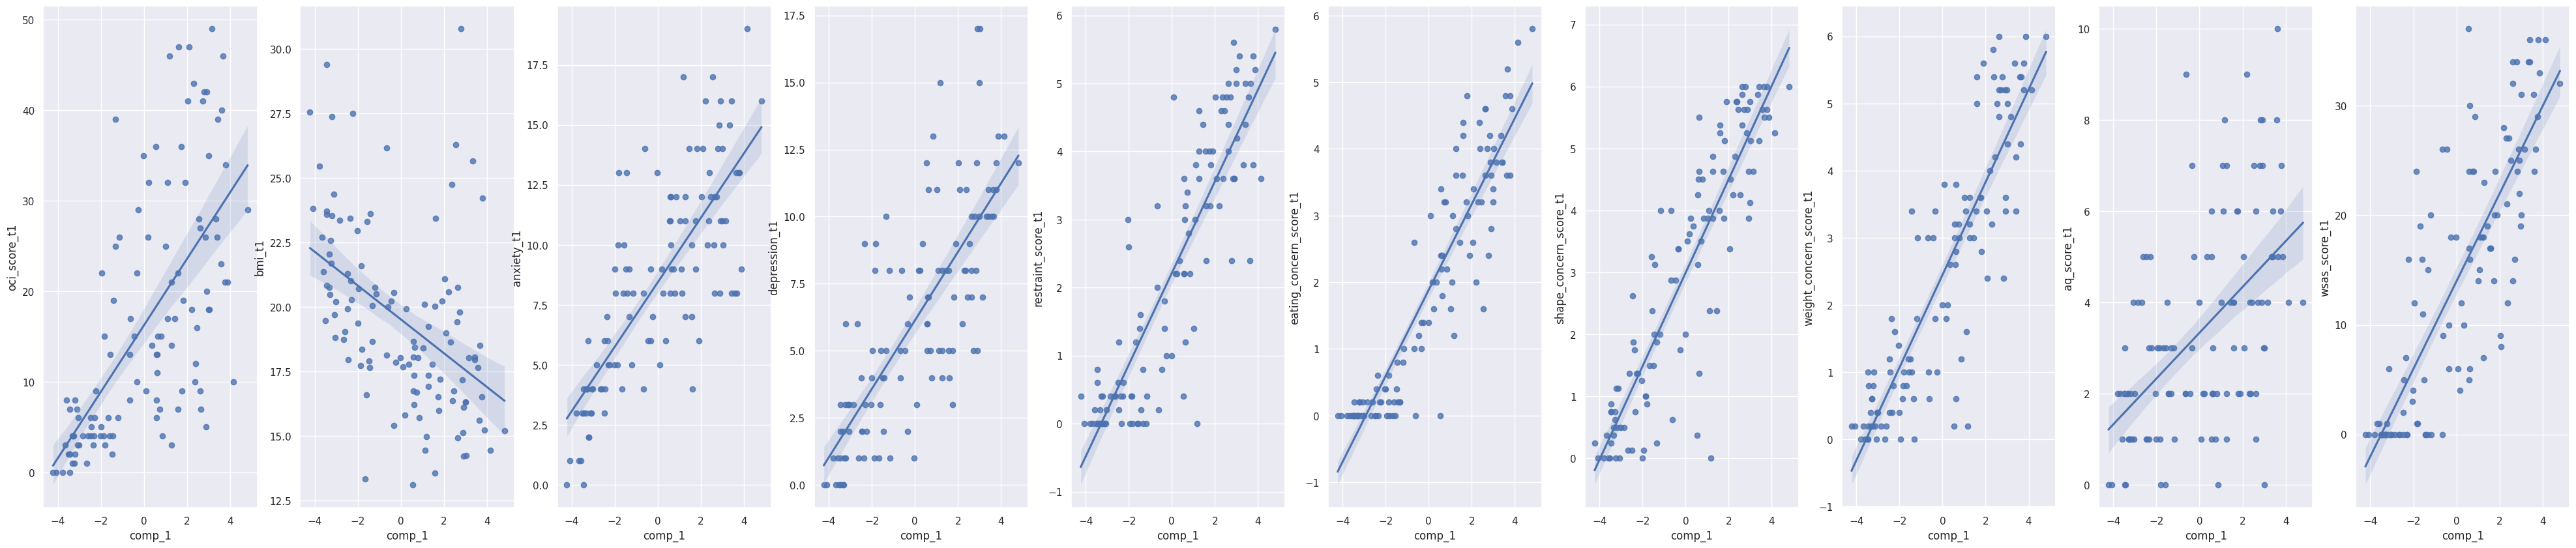

In [103]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_1',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_1'])

{'oci_score_t1': 0.42201793011109956, 'bmi_t1': -0.09682779018772911, 'anxiety_t1': 0.2823431105674509, 'depression_t1': 0.23785862504149805, 'restraint_score_t1': -0.2729888345085837, 'eating_concern_score_t1': -0.2717453952151105, 'shape_concern_score_t1': -0.2972807398009121, 'weight_concern_score_t1': -0.3179140614279427, 'aq_score_t1': 0.6313778175415407, 'wsas_score_t1': -0.03125834956333931}


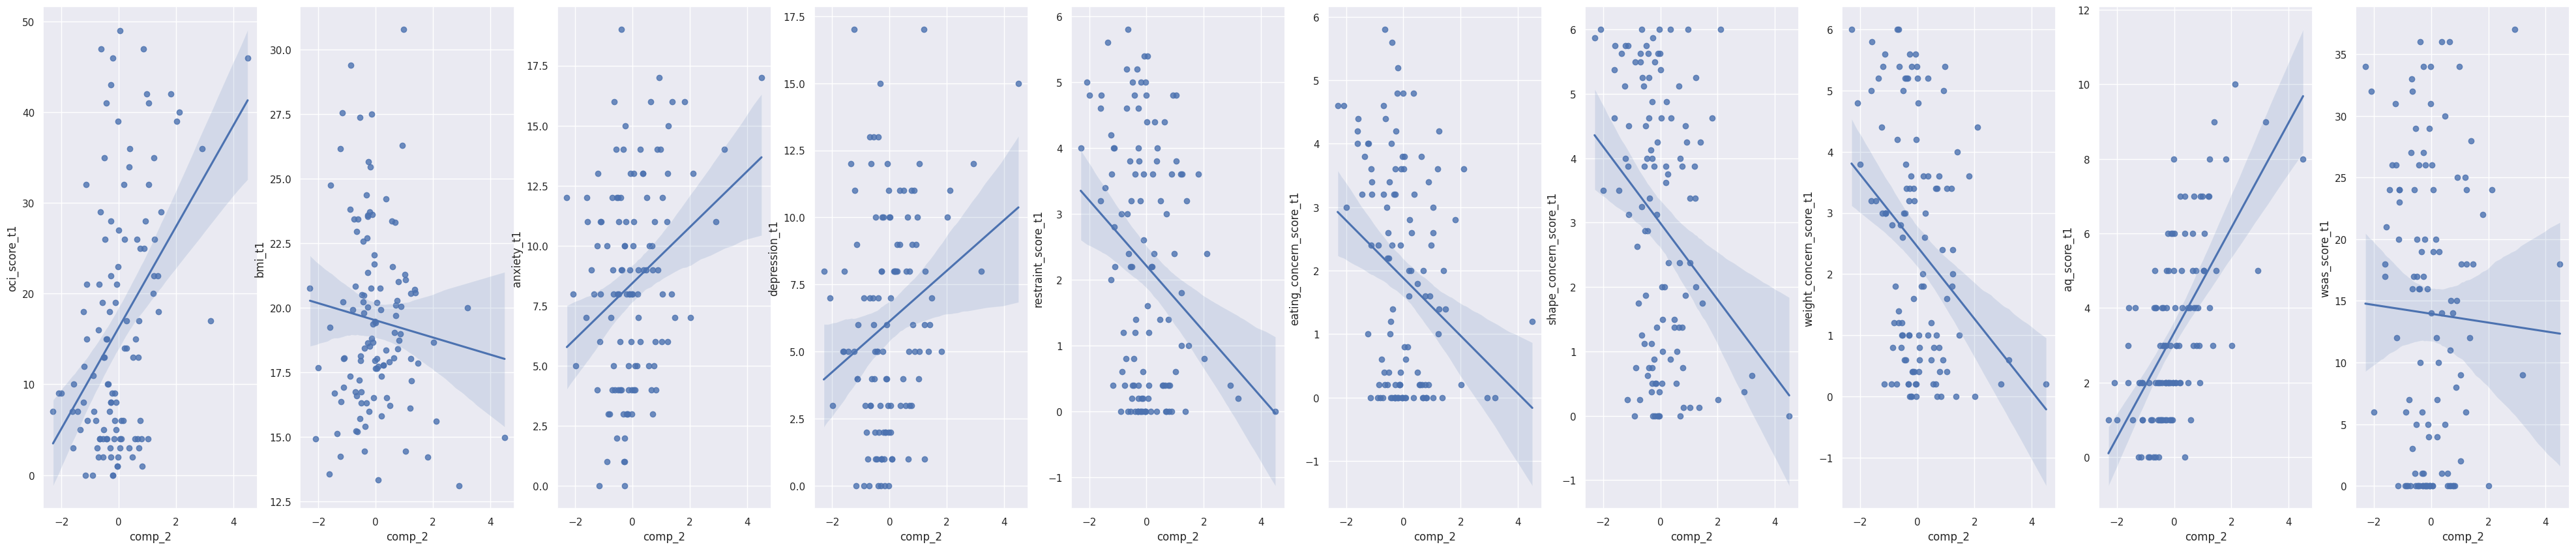

In [104]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_2',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_2'])

{'oci_score_t1': 0.2591732736865425, 'bmi_t1': 0.8325254893381905, 'anxiety_t1': -0.1373572622918285, 'depression_t1': -0.1289807625305926, 'restraint_score_t1': 0.007861491664511824, 'eating_concern_score_t1': -0.005425049173103479, 'shape_concern_score_t1': 0.13183618017283255, 'weight_concern_score_t1': 0.21987254539967263, 'aq_score_t1': 0.23664273498523572, 'wsas_score_t1': -0.033614163573574427}


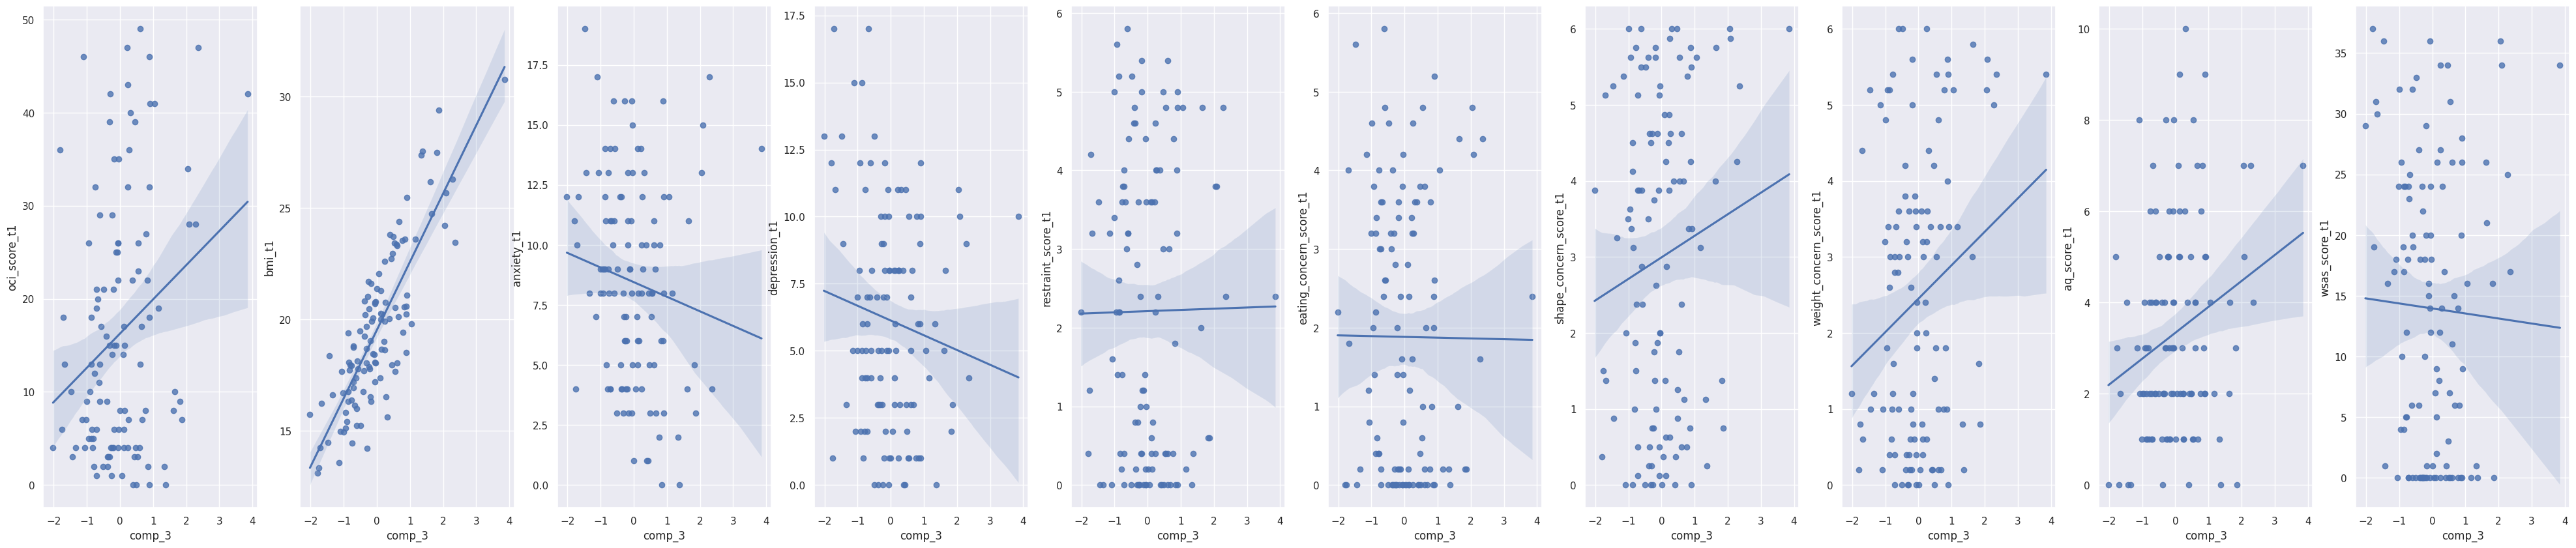

In [105]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_3',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_3'])

{'oci_score_t2': 0.6817813654025744, 'bmi_t2': -0.44984379182862044, 'anxiety_t2': 0.7644749070933936, 'depression_t2': 0.7417556823274754, 'restraint_score_t2': 0.8359334374799886, 'eating_concern_score_t2': 0.8696526570465476, 'shape_concern_score_t2': 0.8822138288488142, 'weight_concern_score_t2': 0.8669870949279339, 'aq_score_t2': 0.4409628870195192, 'wsas_score_t2': 0.8310704358783784}


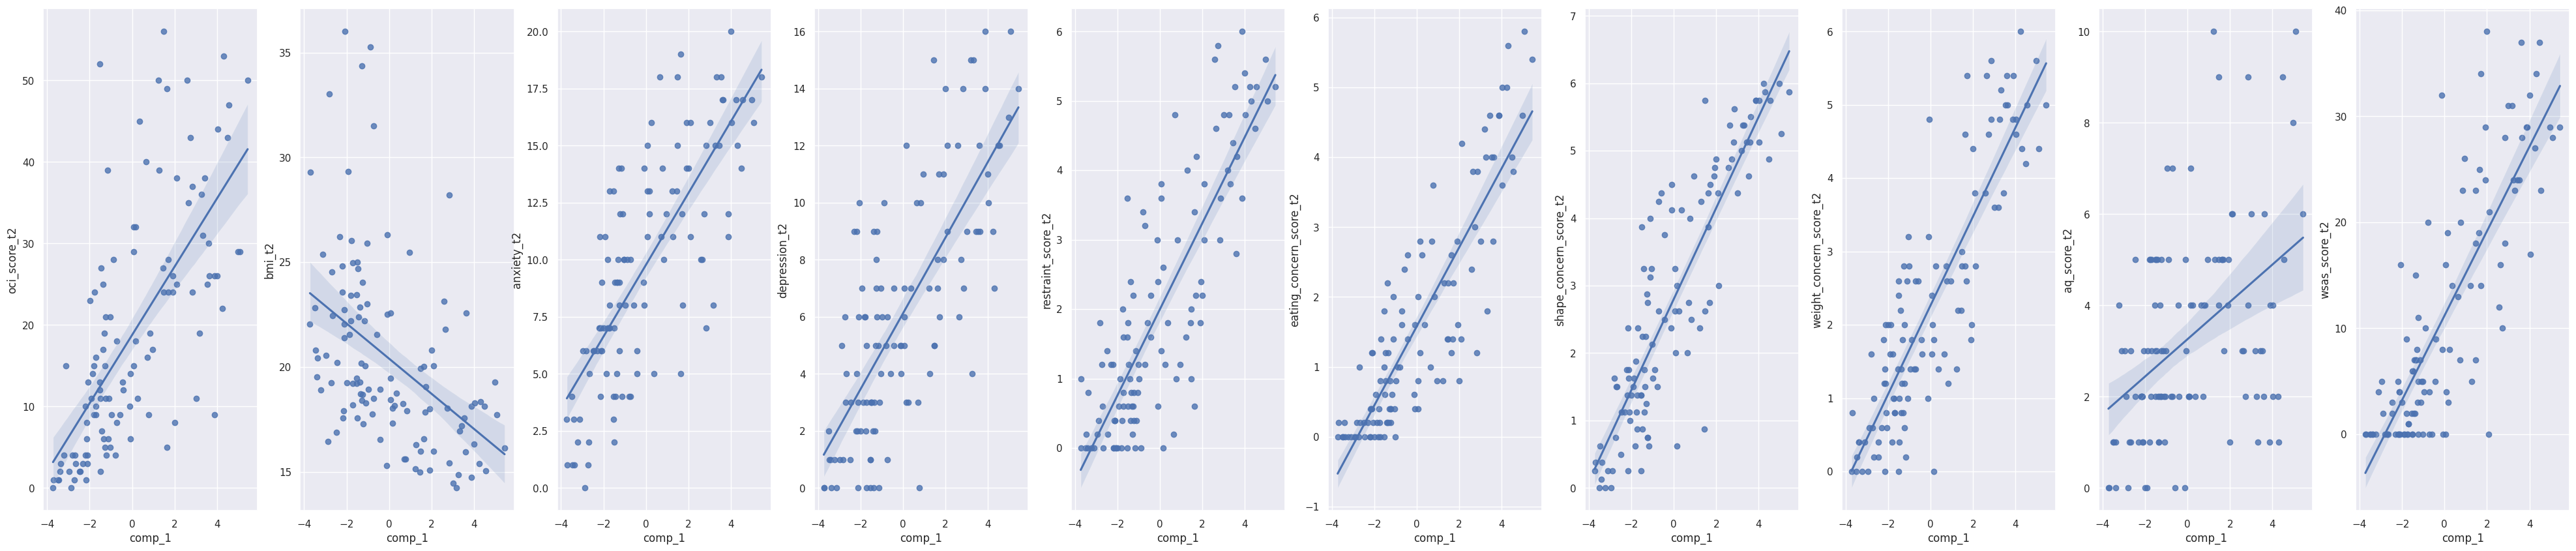

In [106]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_1',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_1'])

{'oci_score_t2': 0.34701104060351207, 'bmi_t2': -0.06686117817609079, 'anxiety_t2': 0.28221195984346115, 'depression_t2': 0.22771803916560238, 'restraint_score_t2': -0.3412052177936721, 'eating_concern_score_t2': -0.22883833462866066, 'shape_concern_score_t2': -0.2864262975478965, 'weight_concern_score_t2': -0.31752880813931056, 'aq_score_t2': 0.7343291037179075, 'wsas_score_t2': 0.04462629690312102}


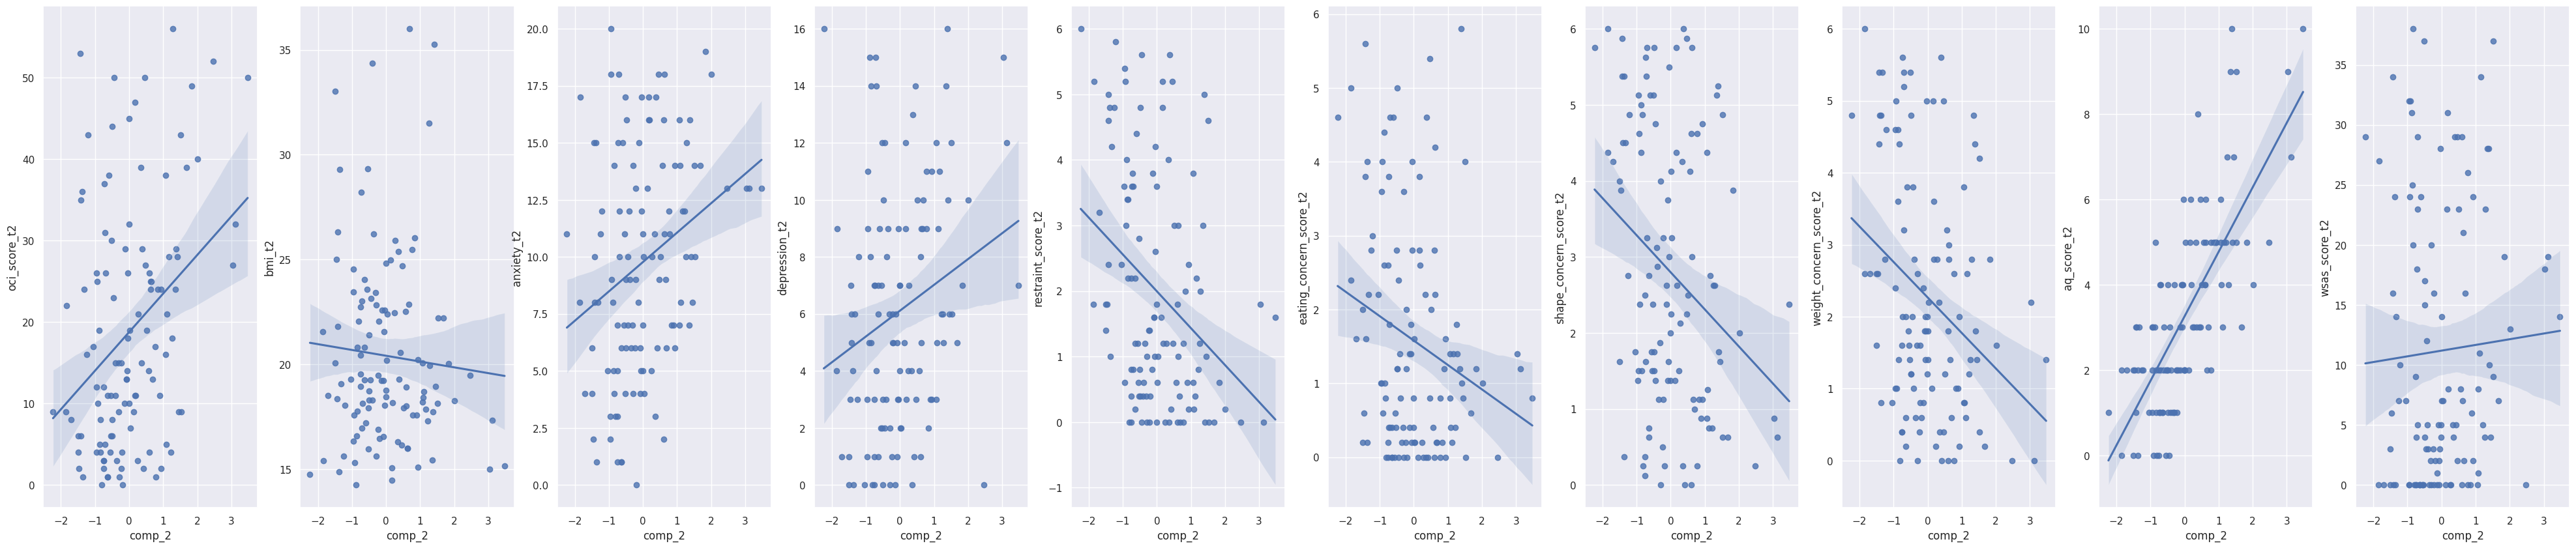

In [107]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_2',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_2'])

{'oci_score_t2': 0.2167141422702703, 'bmi_t2': 0.8658306488471986, 'anxiety_t2': 0.1297850754100305, 'depression_t2': 0.1643477034535798, 'restraint_score_t2': -0.03915844774967048, 'eating_concern_score_t2': -0.08360480625200128, 'shape_concern_score_t2': 0.10620170611932434, 'weight_concern_score_t2': 0.17553501388412485, 'aq_score_t2': -0.04399627861954061, 'wsas_score_t2': -0.12083678526586043}


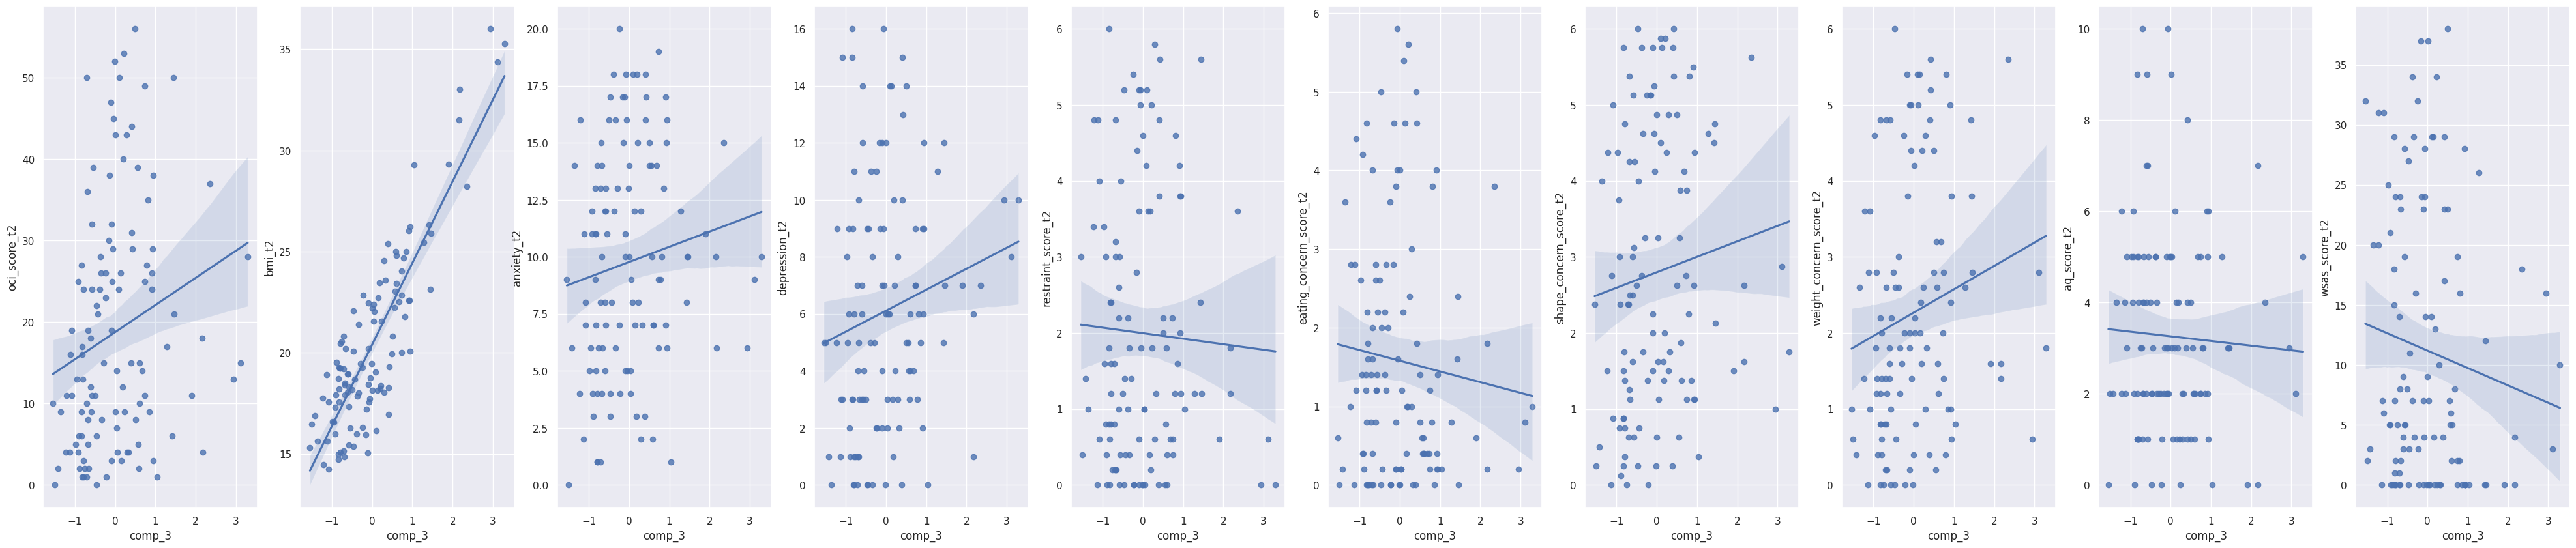

In [108]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_3',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_3'])

## Save dataframes to sql database

In [142]:
pca_t1 = t1_df_seg[['G_Number', 'comp_1', 'comp_2', 'comp_3']]
pca_t2 = t2_df_seg[['B_Number', 'comp_1', 'comp_2', 'comp_3']]
pca_combined_data_set = pd.concat([pca_t1.rename(columns={'comp_1': 'comp_1_t1', 'comp_2': 'comp_2_t1', 'comp_3': 'comp_3_t1'}), pca_t2.rename(columns={'comp_1': 'comp_1_t2', 'comp_2': 'comp_2_t2', 'comp_3': 'comp_3_t2'})], axis=1)
pca_combined_data_set['group'] = pca_df['group']

In [144]:
pca_combined_data_set

,G_Number,comp_1_t1,comp_2_t1,comp_3_t1,B_Number,comp_1_t2,comp_2_t2,comp_3_t2,group
0,G1038,-3.330858,-0.038814,0.053992,B1002,-2.809328,-1.496931,2.171887,HC
1,G1010,-3.675288,-0.306146,0.425690,B1003,-3.492470,-0.294061,-0.220119,HC
2,G1014,-3.462899,-0.216312,0.492204,B1004,-1.462532,0.474414,0.787114,HC
3,G1023,-1.433229,-0.125526,1.165611,B1007,-1.242177,-0.632335,0.733666,HC
4,G1022,-0.338717,1.220852,0.823205,B1009,-0.717742,1.259611,2.164392,HC
...,...,...,...,...,...,...,...,...,...
111,G2141,2.448469,-0.701650,-0.410376,B2091,1.922807,0.933933,-0.793016,AN
112,G2138,-1.598782,-0.656621,-1.344820,B2092,0.064752,-0.222998,-0.289193,AN
113,G2140,2.620445,-2.088359,-0.999341,B2093,3.866470,-2.232530,-0.834078,AN
114,G2105,2.303525,-0.276979,0.238688,B2094,4.305718,-1.430161,0.215596,AN


In [145]:
connector = connect_to_database('BEACON')
pca_t1.to_sql('pca_t1', connector)
pca_t2.to_sql('pca_t2', connector)
pca_combined_data_set.to_sql('pca_df', connector)

-1